In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Check scenario data

In [2]:
# Period of interest
st_yr, end_yr = 2017, 2019

agri_loss_model = "annual"

teo3_base_dir = r"/home/jovyan/shared/common/teotil3"
oslomod_scen_dir = r"/home/jovyan/shared/common/oslofjord_modelling/phase3_scenarios"

scen_list = ["Baseline", "Scenario_A", "Scenario_B"]

# Vassdragsområder of interest
vassom_list = range(1, 18)

In [3]:
# Combine scenario data
df_list = []
for year in range(st_yr, end_yr + 1):
    for scen in scen_list:
        scen_csv = os.path.join(
            oslomod_scen_dir,
            "teotil3_input_files",
            scen,
            f"oslomod_teotil3_input_data_{scen.lower()}_{year}.csv",
        )
        scen_df = pd.read_csv(scen_csv)
        scen_df["year"] = year
        scen_df["scenario"] = scen
        cols = [col for col in scen_df.columns if col.endswith("_kg")]
        id_cols = ["scenario", "year", "regine"]
        scen_df = scen_df[id_cols + cols].groupby(id_cols).sum().reset_index()
        df_list.append(scen_df)
df = pd.concat(df_list, axis="rows")

# Add original TEOTIL3 data for comparison
reg_list = df["regine"].unique().tolist()
df_list = []
for year in range(st_yr, end_yr + 1):
    orig_csv = os.path.join(
        teo3_base_dir,
        "annual_input_data",
        f"agri_{agri_loss_model}_loss",
        f"teotil3_input_data_nve2024_{year}.csv",
    )
    orig_df = pd.read_csv(orig_csv).query("regine in @reg_list")
    orig_df["year"] = year
    orig_df["scenario"] = "Original"
    cols = [col for col in scen_df.columns if col.endswith("_kg")]
    id_cols = ["scenario", "year", "regine"]
    orig_df = orig_df[id_cols + cols].groupby(id_cols).sum().reset_index()
    df_list.append(orig_df)
orig_df = pd.concat(df_list, axis="rows")

df = (
    pd.concat([df, orig_df], axis="rows")
    .drop(columns="regine")
    .groupby(["scenario", "year"])
    .sum()
    .reset_index()
    .melt(id_vars=["scenario", "year"])
)
df[["src", "par", "unit"]] = df["variable"].str.split("_", expand=True)
df["value"] = df["value"] / 1000
df["par"] = df["par"] + "_tonnes"
del df["variable"], df["unit"]

src = "large-wastewater"
df = df.query("src == @src")
df.head()

,scenario,year,value,src,par
780,Baseline,2017,8056.9540,large-wastewater,totn_tonnes
781,Baseline,2018,7567.7067,large-wastewater,totn_tonnes
782,Baseline,2019,7729.3202,large-wastewater,totn_tonnes
783,Original,2017,7816.5769,large-wastewater,totn_tonnes
784,Original,2018,7328.3971,large-wastewater,totn_tonnes


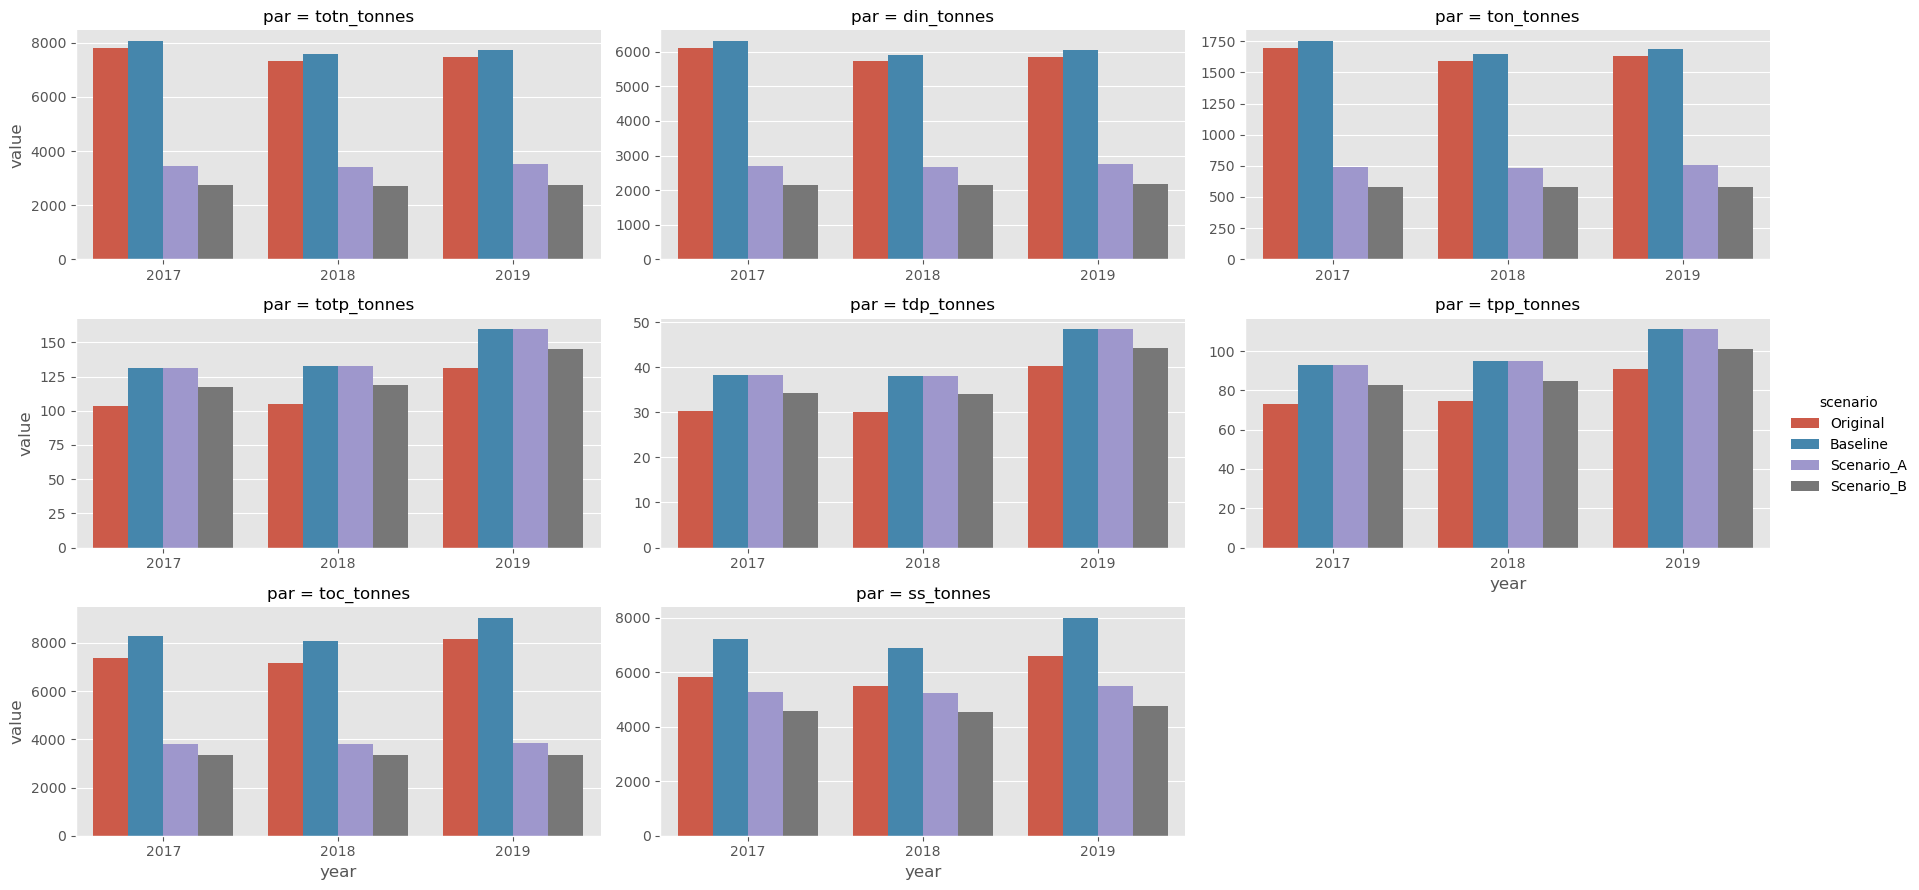

In [4]:
sn.catplot(
    data=df,
    x="year",
    y="value",
    col="par",
    col_wrap=3,
    hue="scenario",
    kind="bar",
    sharey=False,
    sharex=False,
    hue_order=["Original"] + scen_list,
    aspect=2,
    height=3,
)

In [5]:
avg_ww_df = (
    df.groupby(["scenario", "par"])
    .mean(numeric_only=True)
    .drop(columns="year")
    .unstack("scenario")
)
avg_ww_df.columns = avg_ww_df.columns.get_level_values(1)
avg_ww_df.columns.name = ""
avg_ww_df = avg_ww_df.reset_index()

cols = ["Original", "Scenario_A", "Scenario_B"]
for col in cols:
    avg_ww_df[f"{col}_pct"] = (
        100 * (avg_ww_df[col] - avg_ww_df["Baseline"]) / avg_ww_df["Baseline"]
    ).round(1)

pct_cols = [col for col in avg_ww_df.columns if col.endswith("_pct")]
avg_ww_df_pct = avg_ww_df[["par"] + pct_cols].copy()
avg_ww_df_pct

,par,Original_pct,Scenario_A_pct,Scenario_B_pct
0,din_tonnes,-3.1,-55.4,-64.6
1,ss_tonnes,-18.9,-27.6,-37.2
2,tdp_tonnes,-19.3,0.0,-9.6
3,toc_tonnes,-10.7,-54.9,-60.5
4,ton_tonnes,-3.1,-56.0,-65.7
5,totn_tonnes,-3.1,-55.5,-64.8
6,totp_tonnes,-20.0,0.0,-10.0
7,tpp_tonnes,-20.3,0.0,-10.2


## 2. Results

In [6]:
result_csv = os.path.join(
    oslomod_scen_dir, f"teotil3_oslomod_results_{st_yr}-{end_yr}.csv"
)
df = pd.read_csv(result_csv)

main_catches = [f"{i:03d}." for i in vassom_list]
df = df.query("regine in @main_catches")

val_cols = [
    col for col in df.columns if col.startswith("accum_") and col.endswith("_kg")
]
id_cols = ["scenario", "year", "regine"]
df = df[id_cols + val_cols]
df = df.melt(id_vars=id_cols)

df[["stat", "src", "par", "unit"]] = df["variable"].str.split("_", expand=True)
df["value"] = df["value"] / 1000
df["par"] = df["par"] + "_tonnes"
del df["variable"], df["unit"], df["stat"]

df.head()

,scenario,year,regine,value,src,par
0,Baseline,2017,004.,19.138881,agriculture-background,din_tonnes
1,Baseline,2017,005.,9.752400,agriculture-background,din_tonnes
2,Baseline,2017,010.,3.123523,agriculture-background,din_tonnes
3,Baseline,2017,013.,19.612716,agriculture-background,din_tonnes
4,Baseline,2017,008.,4.007513,agriculture-background,din_tonnes


In [7]:
df.query("regine == '007.' and par == 'totn_tonnes' and src == 'large-wastewater'")

,scenario,year,regine,value,src,par
6128,Baseline,2017,007.,0.012394,large-wastewater,totn_tonnes
6145,Baseline,2018,007.,0.012394,large-wastewater,totn_tonnes
6162,Baseline,2019,007.,0.012394,large-wastewater,totn_tonnes
6179,Scenario_A,2017,007.,0.012394,large-wastewater,totn_tonnes
6196,Scenario_A,2018,007.,0.012394,large-wastewater,totn_tonnes
6213,Scenario_A,2019,007.,0.012394,large-wastewater,totn_tonnes
6230,Scenario_B,2017,007.,0.012394,large-wastewater,totn_tonnes
6247,Scenario_B,2018,007.,0.012394,large-wastewater,totn_tonnes
6264,Scenario_B,2019,007.,0.012394,large-wastewater,totn_tonnes


In [8]:
all_df = (
    df.drop(columns="year")
    .groupby(["scenario", "par", "regine"])
    .mean(numeric_only=True)
    .unstack("scenario")
)
all_df.columns = all_df.columns.get_level_values(1)
# all_df.columns.name = None
all_df = all_df.reset_index()

ww_df = (
    df.drop(columns="year")
    .query("src == 'large-wastewater'")
    .groupby(["scenario", "par", "regine"])
    .mean(numeric_only=True)
    .reset_index()
)

cols = ["Scenario_A", "Scenario_B"]
for col in cols:
    all_df[col] = (100 * (all_df[col] - all_df["Baseline"]) / all_df["Baseline"]).round(
        1
    )

del all_df["Baseline"]
all_df = all_df.melt(id_vars=["par", "regine"], value_name="change_pct")
all_df

,par,regine,scenario,change_pct
0,din_tonnes,001.,Scenario_A,-13.2
1,din_tonnes,002.,Scenario_A,-12.3
2,din_tonnes,003.,Scenario_A,-22.7
3,din_tonnes,004.,Scenario_A,-24.1
4,din_tonnes,005.,Scenario_A,-7.6
...,...,...,...,...
267,tpp_tonnes,013.,Scenario_B,-46.9
268,tpp_tonnes,014.,Scenario_B,-59.8
269,tpp_tonnes,015.,Scenario_B,-45.0
270,tpp_tonnes,016.,Scenario_B,-28.7


In [9]:
all_df.query("regine == '007.'")

,par,regine,scenario,change_pct
6,din_tonnes,007.,Scenario_A,-0.7
23,ss_tonnes,007.,Scenario_A,-16.7
40,tdp_tonnes,007.,Scenario_A,-1.4
57,toc_tonnes,007.,Scenario_A,-0.1
74,ton_tonnes,007.,Scenario_A,-0.2
91,totn_tonnes,007.,Scenario_A,-0.5
108,totp_tonnes,007.,Scenario_A,-8.6
125,tpp_tonnes,007.,Scenario_A,-15.5
142,din_tonnes,007.,Scenario_B,-6.8
159,ss_tonnes,007.,Scenario_B,-21.1


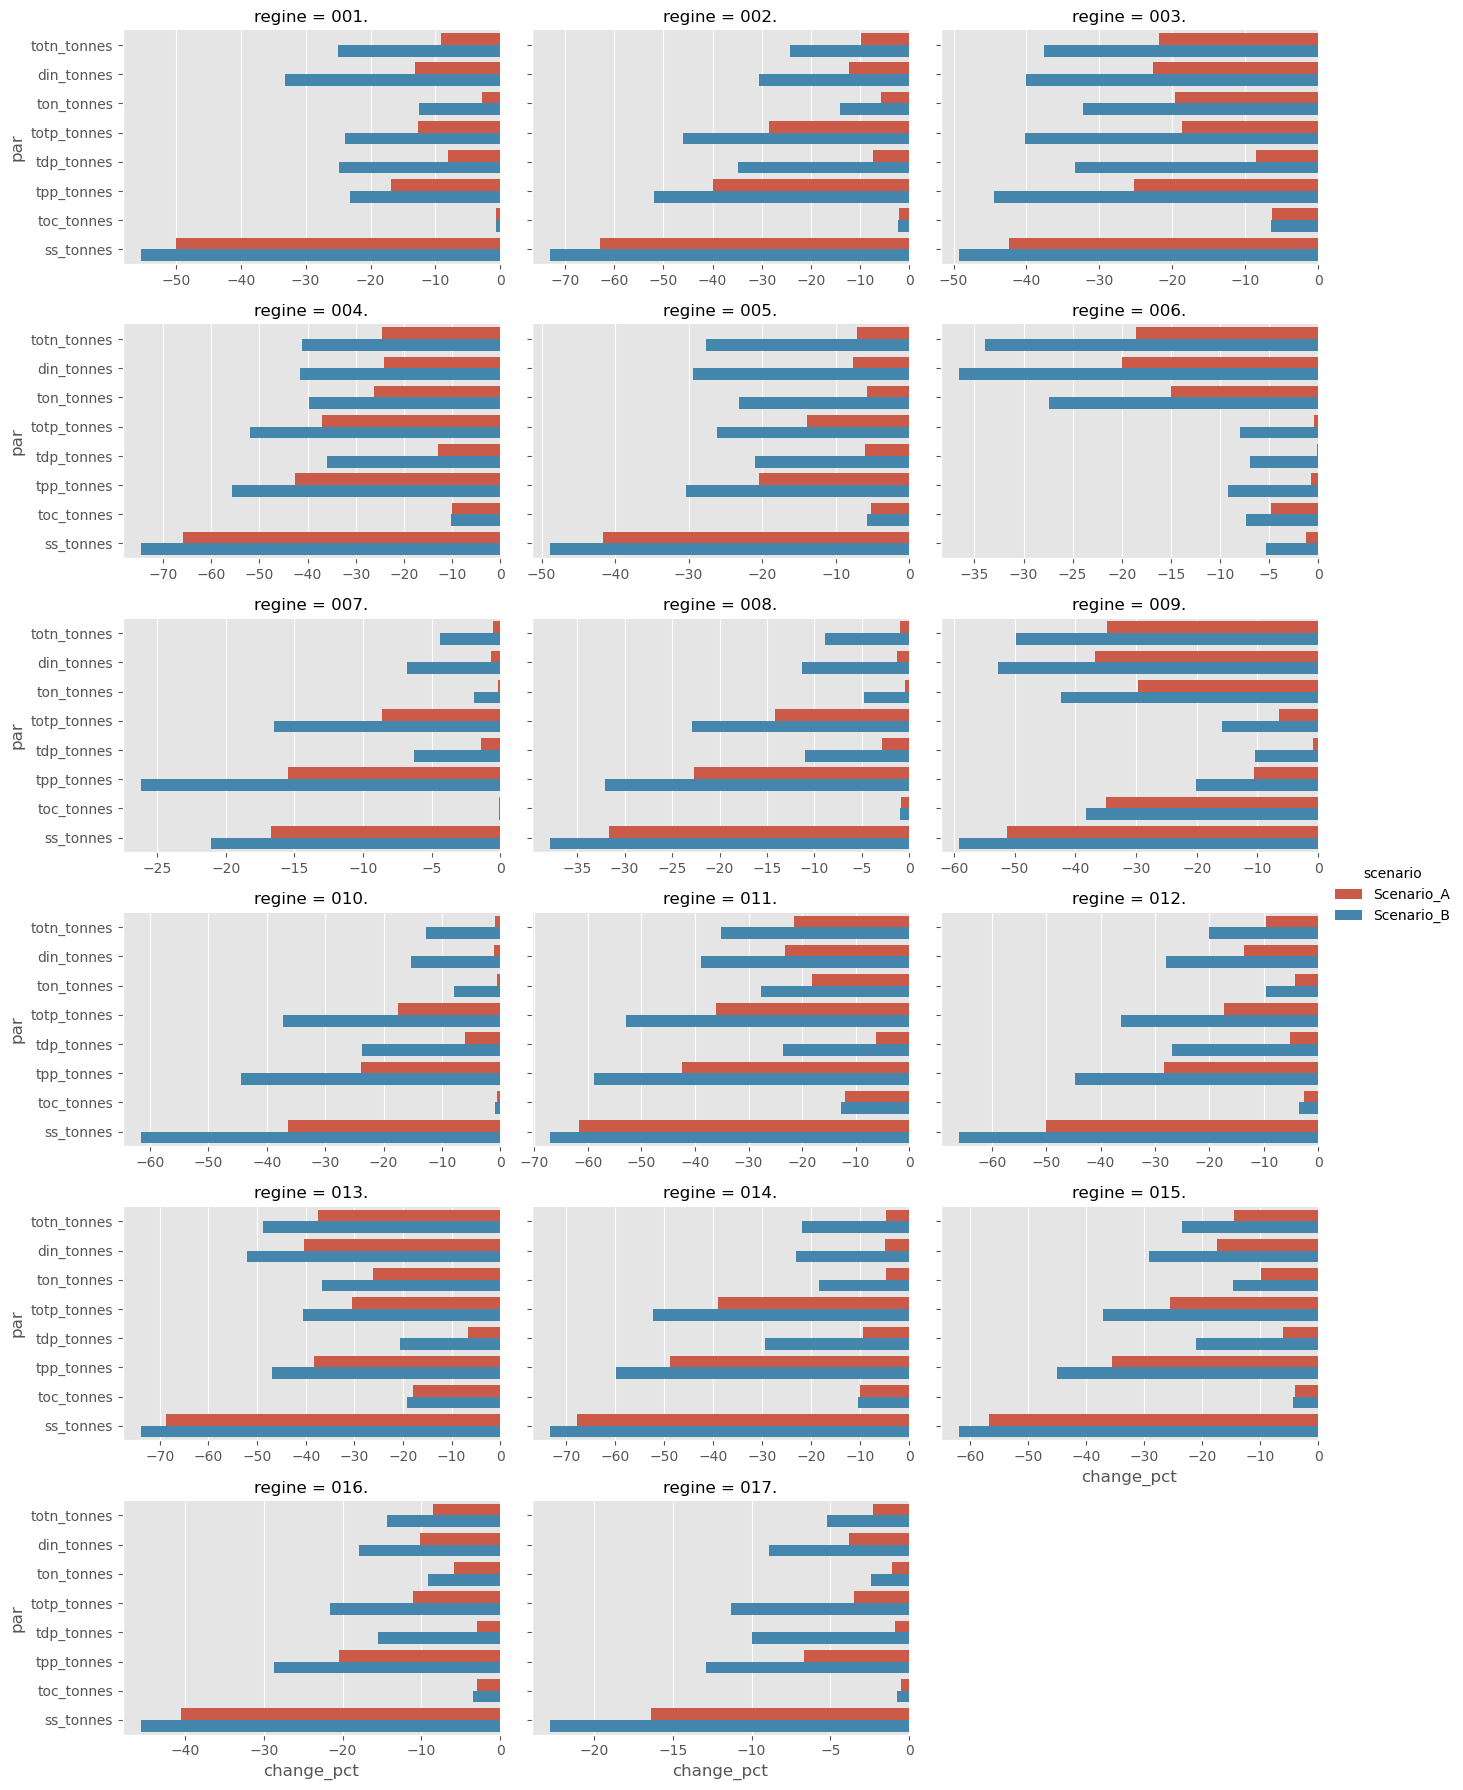

In [10]:
sn.catplot(
    data=all_df,
    x="change_pct",
    y="par",
    # row="regine",
    col="regine",
    col_wrap=3,
    hue="scenario",
    order=[
        "totn_tonnes",
        "din_tonnes",
        "ton_tonnes",
        "totp_tonnes",
        "tdp_tonnes",
        "tpp_tonnes",
        "toc_tonnes",
        "ss_tonnes",
    ],
    kind="bar",
    sharex=False,
    sharey=True,
    aspect=1.5,
    height=3,
)

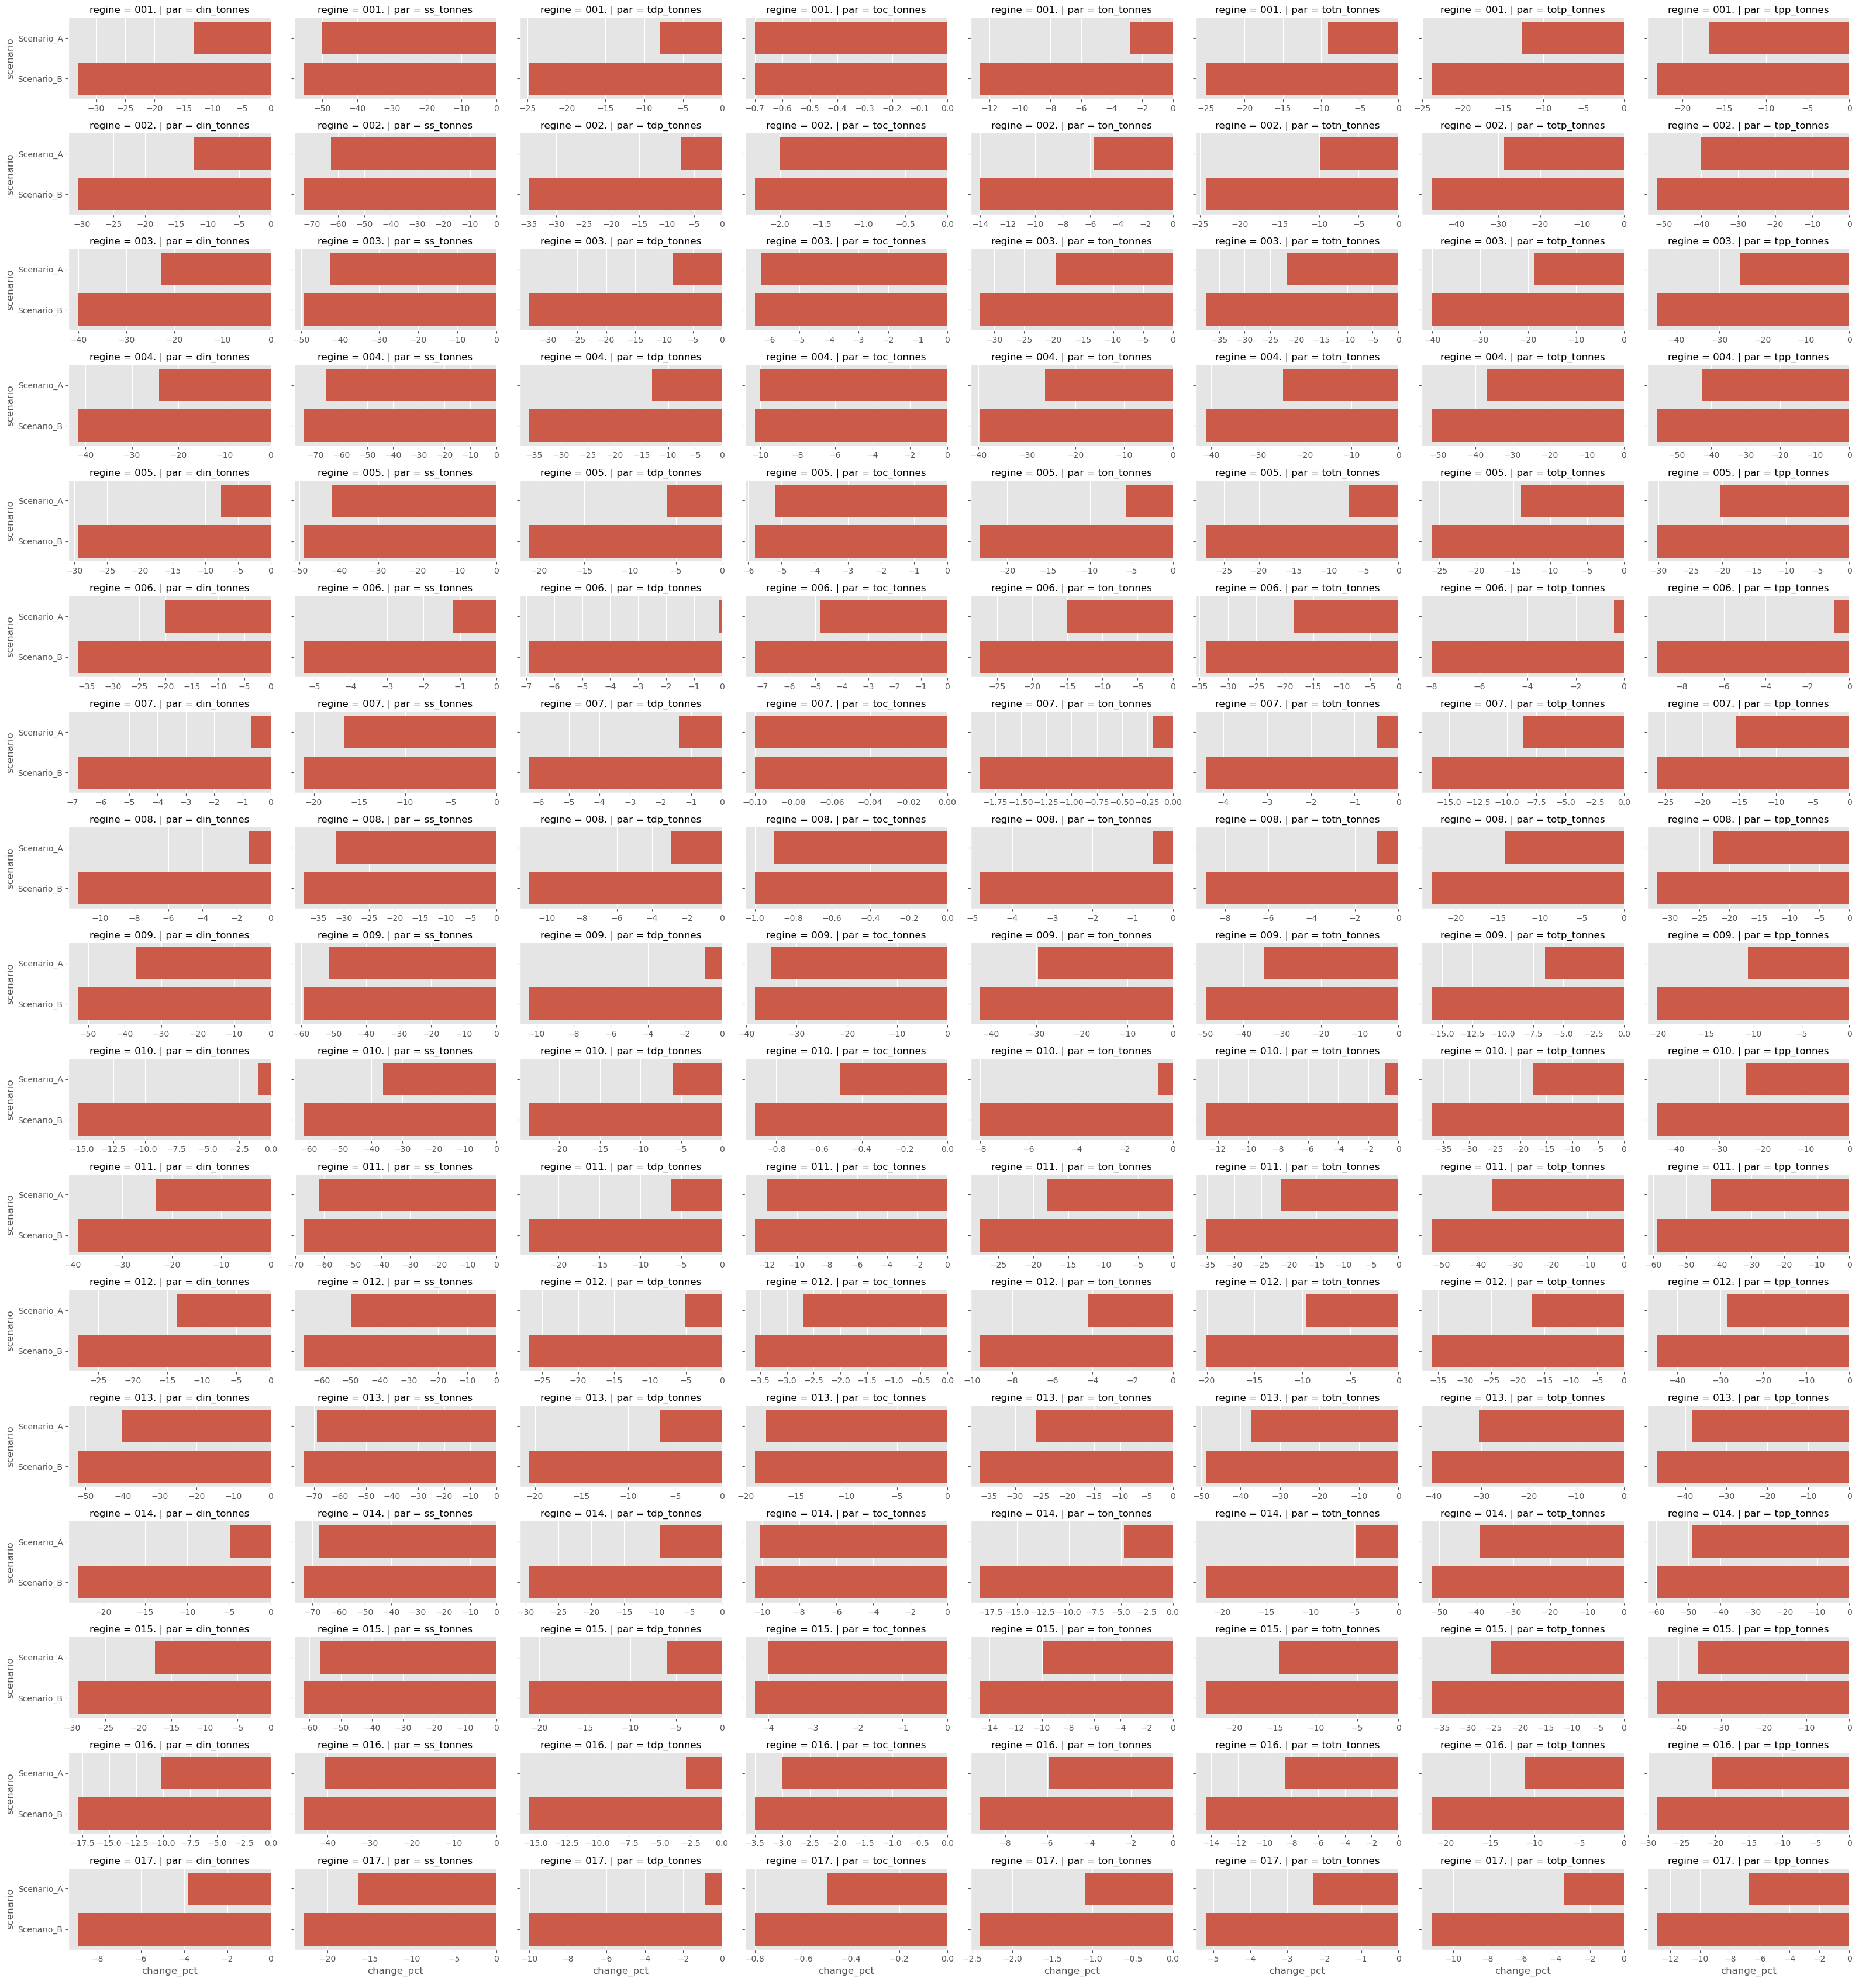

In [11]:
sn.catplot(
    data=all_df,
    x="change_pct",
    y="scenario",
    row="regine",
    col="par",
    kind="bar",
    sharex=False,
    sharey=True,
    aspect=2,
    height=2,
)